<a href="https://colab.research.google.com/github/chloepark627/tensorflow_ex/blob/master/ch07_RNN(7_3_SentimentAnalysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np

In [0]:
path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

In [0]:
train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

In [33]:
print(len(train_text), len(test_text))

6937271 2318260


In [34]:
train_text[:200]

'id\tdocument\tlabel\n9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0\n3819312\t흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나\t1\n10265843\t너무재밓었다그래서보는것을추천한다\t0\n9045019\t교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정\t0\n6483659\t사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서'

In [35]:
print(train_text[:200]) # 0:neg, 1:pos

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서


In [0]:
# Extracting the labels of neg(0) and pos(1)

train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t')>0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t')>0 ])

In [37]:
print(train_Y.shape, test_Y.shape)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


In [40]:
# remove stopwords

import re
# https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py -> 추가 필요

def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)    
    string = re.sub(r"\'{2,}", "\'", string)    
    string = re.sub(r"\'", "", string)    
    return string.strip().lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t')>0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]

sentences = [sentence.split(' ') for sentence in train_text_X]

print(train_text[:200]) # 0:neg, 1:pos
print('\n[정제후]\n')
for i in range(5): print(sentences[i])

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서

[정제후]

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [0]:
print(sentences[0])
print(len(sentences[0]))

['아', '더빙', '진짜', '짜증나네요', '목소리']
5


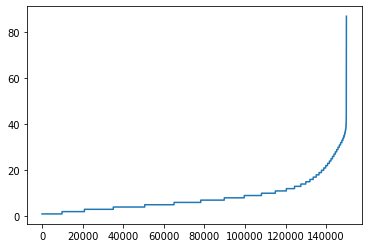

In [41]:
# 문장내 단어(토큰)의 갯수

import matplotlib.pyplot as plt

sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

In [42]:
# 문장 내 단어(토큰) 갯수가 25개 이하
num = sum([int(l<=25) for l in sentence_len])
print(num)

# 전체 중 차지비율 
print(num, len(sentence_len))
print(num/len(sentence_len))

143102
143102 150000
0.9540133333333334


In [0]:
for i in range(5):
    print(sentences[i], len(sentences[i]))

['아', '더빙', '진짜', '짜증나네요', '목소리'] 5
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나'] 6
['너무재밓었다그래서보는것을추천한다'] 1
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정'] 7
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다'] 13


In [43]:
# 문장 내 각 단어의 최대길이 : 5 설정

sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
    
for i in range(5):
    print(sentences[i], len(sentences[i]))
    print(sentences_new[i], len(sentences_new[i]))
    print()

sentences = sentences_new

['아', '더빙', '진짜', '짜증나네요', '목소리'] 5
['아', '더빙', '진짜', '짜증나네요', '목소리'] 5

['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나'] 6
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나'] 6

['너무재밓었다그래서보는것을추천한다'] 1
['너무재밓었'] 1

['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정'] 7
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정'] 7

['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다'] 13
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다'] 13



In [47]:
# 토큰화(한글 단어 -> 단어의 인덱스(숫자))

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)

print(sentences[0])
train_X = tokenizer.texts_to_sequences(sentences)
print(train_X[0])

['아', '더빙', '진짜', '짜증나네요', '목소리']
[24, 884, 7, 5798, 1111]


In [48]:
# 0패딩추가해서 한 문장 당 25단어(갯수)로 맞추기

print(train_X[:5])
train_X = pad_sequences(train_X, padding='post')
print()
print(train_X[:5])

[[24, 884, 7, 5798, 1111], [588, 5799, 6699], [], [70, 346, 30, 34, 10469], [105, 5338, 3, 1, 2171, 870, 573]]

[[   24   884     7  5798  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5799  6699     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   70   346    30    34 10469     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  105  5338     3     1  2171   870   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


In [0]:
print(tokenizer.index_word[19999])
print(tokenizer.index_word[20000])

짐캐리가
필요있나


In [0]:
temp = tokenizer.texts_to_sequences(['경우는', '잊혀질', '연기가', '햇빛이쨍쨍'])
print(temp)
temp = pad_sequences(temp, padding='post')
print(temp)

[[], [], [105], []]
[[  0]
 [  0]
 [105]
 [  0]]


In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length=25), # 25개의 단어 -> 300(길이)의 벡터(:임베딩 벡터)로 변환
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(2, activation='softmax') # predicted : [neg %, pos %]
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 300)           6000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


In [50]:
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
938/938 [==============================] - 58s 62ms/step - loss: 0.4362 - accuracy: 0.7808 - val_loss: 0.3977 - val_accuracy: 0.8086
Epoch 2/5
938/938 [==============================] - 58s 62ms/step - loss: 0.3255 - accuracy: 0.8465 - val_loss: 0.3925 - val_accuracy: 0.8182
Epoch 3/5
938/938 [==============================] - 58s 61ms/step - loss: 0.2723 - accuracy: 0.8704 - val_loss: 0.4090 - val_accuracy: 0.8158
Epoch 4/5
938/938 [==============================] - 58s 61ms/step - loss: 0.2272 - accuracy: 0.8892 - val_loss: 0.4685 - val_accuracy: 0.8061
Epoch 5/5
938/938 [==============================] - 57s 61ms/step - loss: 0.1938 - accuracy: 0.9043 - val_loss: 0.5527 - val_accuracy: 0.8077


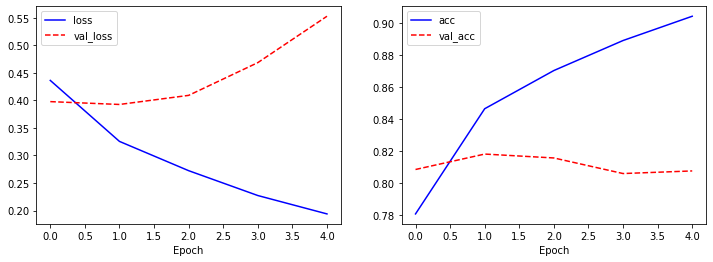

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='acc')
plt.plot(history.history['val_accuracy'], 'r--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [0]:
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t')>0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]

sentences = [sentence.split() for sentence in test_text_X]

sentences_new = list()

for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])

sentences = sentences_new

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding='post')

In [55]:
model.evaluate(test_X, test_Y, verbose=0)

[0.5631316304206848, 0.8006200194358826]

In [57]:
test_sentence = '내 생각에 이 영화는 지루하고, 너무 따분하고, 재미가 없었다. 내 돈이 아깝다.'
test_sentences = test_sentence.split()

test_sentence = []
now_sentence = []

for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])

print(test_sentences)

test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=25)

prediction = model.predict(test_X_1)

for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])    

['내', '생각에', '이', '영화는', '지루하고,', '너무', '따분하고,', '재미가', '없었다.', '내', '돈이', '아깝다.']
내
[0.48412117 0.51587886]
생각에
[0.07320221 0.9267978 ]
이
[0.40841252 0.5915875 ]
영화는
[0.52043843 0.4795616 ]
지루하고,
[0.96076035 0.03923967]
너무
[0.6581064  0.34189358]
따분하고,
[0.97884387 0.02115614]
재미가
[0.8281296 0.1718704]
없었다.
[0.6578287  0.34217125]
내
[0.48412117 0.51587886]
돈이
[0.96561897 0.03438102]
아깝다.
[0.9860952  0.01390484]
